In [14]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import jax.random as random
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *
import h5py

In [15]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_05_uvx.h5', 'r') as f:
    v = f['v'][:1000]
    u = f['u'][:1000]
    T = f['T'][:1000]
    x = f['x'][:1000]
    f.close()

In [16]:
def define_MSD(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(spacing):
        kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params['spacing']), mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    
    if kwargs_sys['eta_var'] == True: 
        @jit
        def eom(y, t, params, iparams, exparams):
                
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = par['D']*laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active_n_var(x,T,par,kwargs_sys) + force_field_passive_n_var(x,par,kwargs_sys) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    else:
        @jit
        def eom(y, t, params, iparams, exparams):
                
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = par['D']*laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        pad = 10
        x = ys['x'][:,:,pad:-pad,pad:-pad]
        x_target = targets['x'][:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][:,:,pad:-pad,pad:-pad]
        
        return  jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#jnp.nanmean((u - u_target)**2) +
            
    return eom, loss, gen_params, gen_y0, {}

def define_MSD_rec(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']

    def gen_params():
        return {key:value + kwargs_sys['par_tol']*value*np.random.uniform(-1.0, 1.0) for key,value in kwargs_sys['params_true'].items()}, {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    @jit
    def kernel(spacing):
        kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (spacing* spacing * 6)
        return kernel
    @jit
    def laplace(f,params):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel(params['spacing']), mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    
    if kwargs_sys['eta_var'] == True: 
        @jit
        def eom(y, t, params, iparams, exparams):
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = par['D']*laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active_n_var_rec(x,T,par,kwargs_sys['n_gaussians']) + force_field_passive_n_var_rec(x,par,kwargs_sys['n_gaussians']) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    else:
        @jit
        def eom(y, t, params, iparams, exparams):
                par=params
                u=y['u']
                v=y['v']
                T=y['T']
                x=y['x']
                x_dot=y['x_dot']

                dudt = par['D']*laplace(u,par)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
                dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
                dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
                dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) + force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])
                dxdt = x_dot

                return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    
    @jit
    def loss(ys, params, iparams, exparams, targets):
        # u = ys['u']
        # u_target = targets['u']
        pad = 10
        x = ys['x'][:,:,pad:-pad,pad:-pad]
        x_target = targets['x'][:,:,pad:-pad,pad:-pad]
        x_dot = ys['x_dot'][:,:,pad:-pad,pad:-pad]
        x_dot_target = targets['x_dot'][:,:,pad:-pad,pad:-pad]
        u_target = targets['u']
        u = ys['u']
        return  jnp.nanmean((x - x_target)**2 + (x_dot-x_dot_target)**2)#+ jnp.nanmean((u - u_target)**2)
            
    return eom, loss, gen_params, None, {}

def compute_log_div(data):
    """
    Compute the largest Lyapunov exponent from reaction-diffusion system data.
    
    Parameters:
    data (numpy.ndarray): 3D array of shape (t, 100, 100), where t is time.
    
    Returns:
    float: Estimated largest Lyapunov exponent (lambda_max).
    """
    t, x, y = data.shape  # Extract dimensions
    states = data.reshape(t, -1)  # Flatten spatial dimensions
    
    # Compute Euclidean distances between consecutive states
    distances = np.linalg.norm(states[1:] - states[:-1], axis=1)
    
    # Avoid division by zero
    if distances[0] == 0:
        raise ValueError("Initial distance is zero; choose different initial conditions.")
    
    # Compute log divergence over time
    log_divergence = np.log(distances / distances[0])
    
    return log_divergence  # Largest Lyapunov exponent

def expand_dict_arrays(data_dict, N_sys):
    """
    Expands each array in the dictionary along the first axis to shape (N_sys, ...).
    
    Parameters:
    - data_dict (dict): Dictionary with arrays of shape (1, ...)
    - N_sys (int): Number of copies along the first axis

    Returns:
    - expanded_dict (dict): Dictionary with arrays of shape (N_sys, ...)
    """
    return {key: np.tile(arr, (N_sys, *[1] * (arr.ndim - 1))) for key, arr in data_dict.items()}


In [17]:
@jit
def get_n_dist(n_dict,params):
    filtered_keys = n_dict.keys()
    
    indices = jnp.array([(int(k[1:3]), int(k[3:5])) for k in filtered_keys])
    values = jnp.array([params[k] for k in filtered_keys])

    # Initialize an empty JAX array
    n_distr_reconstructed = jnp.zeros((100, 100))

    # Populate the array using indexed assignment
    n_distr_reconstructed = n_distr_reconstructed.at[indices[:, 0], indices[:, 1]].set(values)
    return n_distr_reconstructed

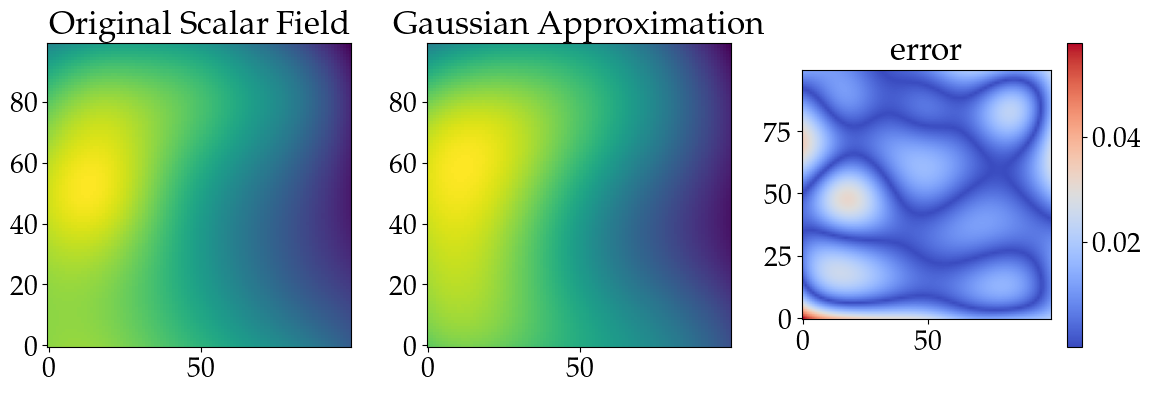

In [42]:
# # Generate or load the 2D scalar field (n_dist)
# np.random.seed(42)
# n_points = 100
n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')

n_points = n_dist.shape[0]
y = np.linspace(-1, 1, n_points)

X, Y = np.meshgrid(y, y)
# n_dist = np.exp(-((X**2 + Y**2) / 0.1)) + 0.1 * np.random.rand(n_points, n_points)  # Example scalar field
# Define Gaussian basis function

# Generate basis function centers
n_gaussians = 4  # Number of Gaussian basis functions
centers = np.linspace(-1, 1, n_gaussians)
sigma = 1  # Fixed width for all Gaussians

# Create a design matrix of Gaussian basis functions
def basis_matrix(X, Y, centers, sigma):
    features = []
    for x0 in centers:
        for y0 in centers:
            features.append(gaussian_2d(x0, y0, 1).flatten())  # Amplitude = 1 for now
    return np.array(features).T  # Shape (N_samples, N_basis)

# Compute basis functions for given centers
Phi = basis_matrix(X, Y, centers, sigma)

# Solve for weights using least squares regression
coeffs, _, _, _ = np.linalg.lstsq(Phi, n_dist.flatten(), rcond=None)
params_gaussian = coeffs_to_params(coeffs)

# Reconstruct the field using the fitted coefficients
reconstructed = Phi @ coeffs
reconstructed = reconstructed.reshape(n_points, n_points)
# reconstructed = sum_gaussian(n_gaussians,params_gaussian)
# Plot results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(n_dist, cmap='viridis', origin='lower')
axes[0].set_title("Original Scalar Field")

axes[1].imshow(reconstructed, cmap='viridis', origin='lower')

axes[1].set_title("Gaussian Approximation")

axes[2].imshow(np.abs(n_dist - reconstructed), cmap='coolwarm', origin='lower')
axes[2].set_title("error")
plt.colorbar(axes[2].imshow(np.abs(n_dist - reconstructed), cmap='coolwarm', origin='lower'))
plt.tight_layout()
plt.show()


In [19]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,params = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
                             ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
                             'n_0','l_0','spacing'],mode = 'chaos')
keys =['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
        ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
        'n_0','l_0','spacing']
n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')
tol = 0

params_true = dict(zip(keys,params))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}

x_dot = np.gradient(x, axis=0) / params_true['delta_t_e']

length,sampling_rate = 5,20
pad = 10
u0,v0,T0,x0,x_dot0,t_evals = u[0],v[0],T[0],x[0],x_dot[0],np.linspace(0, params_true['delta_t_e']*sampling_rate*length, length)
print(n_dist.shape)
kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'n_dist': n_dist,
              'eta_var': True,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'lr':2e-3}

(100, 100)


In [25]:
Simulation_MSD = simple_simulation(define_MSD,
                                t_evals,
                                kwargs_sys,
                                kwargs_adoptODE)


In [26]:
u_sim = Simulation_MSD.ys['u'][0]
x_sim = Simulation_MSD.ys['x'][0]
dA_sim = compute_dA(x_sim, 1)
dA = compute_dA(x, 1)
 
vmin,vmax =  0,1
pad = 10

# Function to update the plot

def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dA_sim[frame,pad:-pad,pad:-pad], cmap='coolwarm', vmin=-.2 ,vmax=.2)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"dA")
    
    # Plot dA_sim
    im2 = axes[1].matshow(u_sim[frame], cmap='coolwarm')
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"u")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"u")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=dA_sim.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# # Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=4)

Output()

## Use Simulation data as ground trouth

In [9]:


params_true = Simulation_MSD.params_train
fit_indx = 0
pad = 10

# u0,v0,T0,x0,x_dot0,t_evals = get_ini_fit(u_sim,v_sim,T_sim,x_sim,x_dot_sim,fit_indx,sampling_rate=sampling_rate,length=length)

In [10]:
tol = .5

params_gaussian = {'Amp'+str(i)+str(j):0.1 for i in range(3) for j in range(3)}
params_gaussian_low = {'Amp'+str(i)+str(j):-1 for i in range(3) for j in range(3)}
params_gaussian_high = {'Amp'+str(i)+str(j):1 for i in range(3) for j in range(3)}
params_true = dict(zip(keys,params))|params_gaussian
params_low = {key: value - value*tol for key, value in params_true.items()}|params_gaussian_low
params_high = {key: value + value*tol for key, value in params_true.items()}|params_gaussian_high
params_high['k_ij_pad'],params_low['k_ij_pad'] = params_true['k_ij_pad']  ,params_true['k_ij_pad']
params_high['k_a_pad'],params_low['k_a_pad'] = params_true['k_a_pad']  ,params_true['k_a_pad']

In [11]:
targets = {'u':jnp.full((Simulation_MSD.ys['u'].shape),.5),'v': jnp.zeros_like(Simulation_MSD.ys['v']),'T':jnp.zeros_like(Simulation_MSD.ys['T']),
           'x':Simulation_MSD.ys['x'],'x_dot':Simulation_MSD.ys['x_dot']}
N_sys = 1  # Number of copies
targets = expand_dict_arrays(targets, N_sys)

kwargs_sys = {'size': 100,
              'N_sys': N_sys,
              'par_tol': tol,
              'n_dist': n_dist,
              'n_gaussians':3,
              'params_true': params_true,
              'eta_var': True}
kwargs_adoptODE = {'epochs': 50,'N_backups': 3,'lr': 3e-2,'lower_b': params_low,'upper_b': params_high,
                   'lr_y0':3e-2,
                   'lower_b_y0':{'u':0,'v':0,'T':0,'x':x0,'x_dot':x_dot0},
                    'upper_b_y0':{'u':1,'v':np.max(v),'T':np.max(T),'x':x0,'x_dot':x_dot0}}
dataset_MSD = dataset_adoptODE(define_MSD_rec,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)

In [12]:
params_final, losses, errors, params_history = train_adoptODE(dataset_MSD, print_interval=10, save_interval=10)
print('Found params: ', dataset_MSD.params_train)

E0311 11:40:18.442545  229573 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: RESOURCE_EXHAUSTED: CUDA driver ran out of memory trying to instantiate CUDA graph with 116 nodes and 0 conditionals (total of 0 alive CUDA graphs in the process). You can try to (a) Give more memory to CUDA driver by reducing XLA_PYTHON_CLIENT_MEM_FRACTION (b) Disable CUDA graph with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph:CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: RESOURCE_EXHAUSTED: CUDA driver ran out of memory trying to instantiate CUDA graph with 116 nodes and 0 conditionals (total of 0 alive CUDA graphs in the process). You can try to (a) Give more memory to CUDA driver by reducing XLA_PYTHON_CLIENT_MEM_FRACTION (b) Disable CUDA graph with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph:CUDA_ERROR_OUT_OF_MEMORY: out of memory

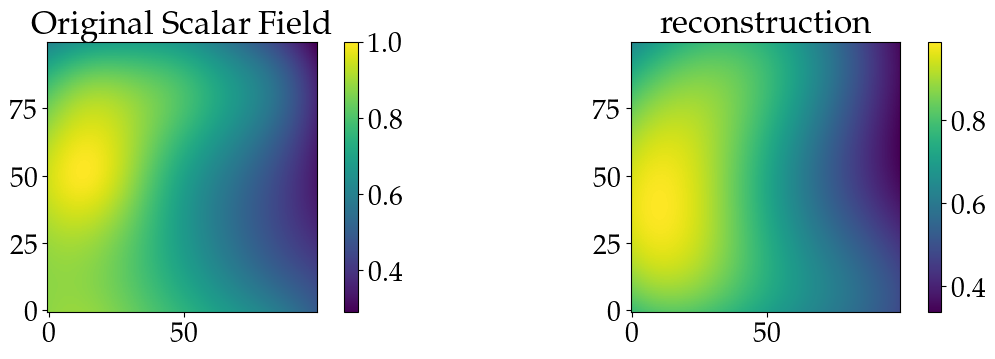

In [ ]:
n_dist = np.load('../data/SpringMassModel/FiberOrientation/fiber_orientation.npy')
n_dist_train = sum_gaussian(3,dataset_MSD.params_train)
n_points = n_dist.shape[0]
y = np.linspace(-1, 1, n_points)

X, Y = np.meshgrid(y, y)
# n_dist = np.exp(-((X**2 + Y**2) / 0.1)) + 0.1 * np.random.rand(n_points, n_points)  # Example scalar field
# Define Gaussian basis function

# Generate basis function centers
n_gaussians = 3  # Number of Gaussian basis functions
centers = np.linspace(-1, 1, n_gaussians)
sigma = 1  # Fixed width for all Gaussians

# Create a design matrix of Gaussian basis functions
def basis_matrix(X, Y, centers, sigma):
    features = []
    for x0 in centers:
        for y0 in centers:
            features.append(gaussian_2d(x0, y0, 1).flatten())  # Amplitude = 1 for now
    return np.array(features).T  # Shape (N_samples, N_basis)

# Compute basis functions for given centers
Phi = basis_matrix(X, Y, centers, sigma)

# Solve for weights using least squares regression
coeffs, _, _, _ = np.linalg.lstsq(Phi, n_dist.flatten(), rcond=None)
params_gaussian = coeffs_to_params(coeffs)

# Reconstruct the field using the fitted coefficients
reconstructed = Phi @ coeffs
reconstructed = reconstructed.reshape(n_points, n_points)
reconstructed = sum_gaussian(n_gaussians,params_gaussian)
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(n_dist, cmap='viridis', origin='lower')
axes[0].set_title("Original Scalar Field")
plt.colorbar(axes[0].imshow(n_dist, cmap='viridis', origin='lower'))

axes[1].imshow(n_dist_train, cmap='viridis', origin='lower')

axes[1].set_title("reconstruction")
plt.colorbar(axes[1].imshow(n_dist_train, cmap='viridis', origin='lower'))


plt.tight_layout()
plt.show()

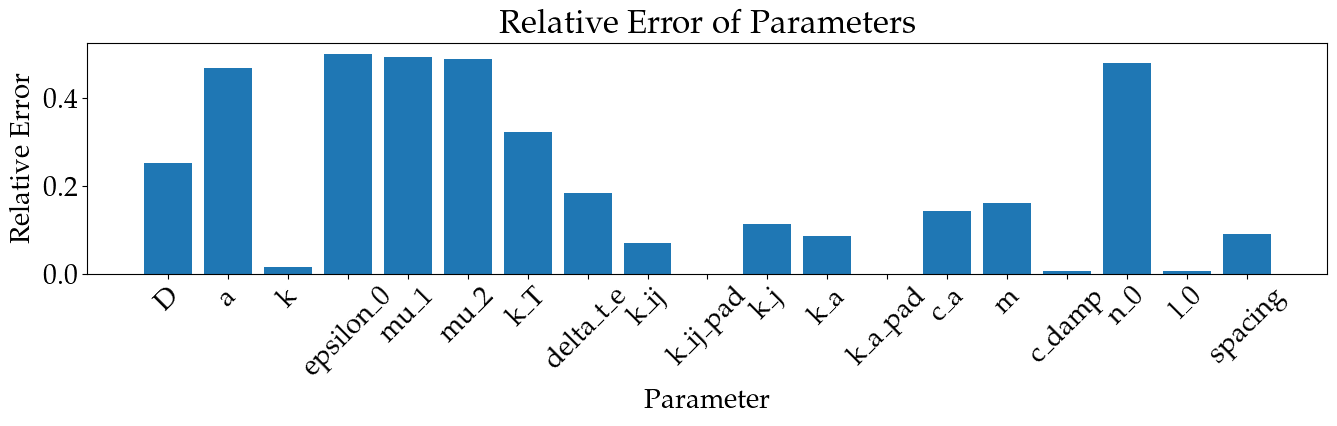

In [ ]:
#show diagram of all param errors
params_rec = dataset_MSD.params_train
param_names = keys
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = params_rec.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()


In [ ]:
x_rec = dataset_MSD.ys_sol['x'][0]
x_dot_rec = dataset_MSD.ys_sol['x_dot'][0]
T_rec = dataset_MSD.ys_sol['T'][0]
u_rec = dataset_MSD.ys_sol['u'][0]
v_rec = dataset_MSD.ys_sol['v'][0]
u_sim = Simulation_MSD.ys['u'][0]

u_err = u_rec - u_sim
 
vmin,vmax =  0,1
pad = 10

# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(u_rec[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(u_sim[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_err[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=u_sim.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=4)

Output()

## second simulation

In [ ]:
u0,v0,T0,x0,x_dot0,t_evals = Simulation_MSD.ys['u'][0,-1],Simulation_MSD.ys['v'][0,-1],Simulation_MSD.ys['T'][0,-1],Simulation_MSD.ys['x'][0,-1],Simulation_MSD.ys['x_dot'][0,-1],np.linspace(0, params_true['delta_t_e']*sampling_rate*length, length)

kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'par_tol': 0,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3}
Simulation_MSD_2 = simple_simulation(define_MSD,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)

KeyError: 'n_dist'

In [ ]:
u_tar,v_tar,T_tar = jnp.broadcast_to(dataset_MSD.ys_sol['u'][0,-1],(1,length,100,100)),jnp.broadcast_to(dataset_MSD.ys_sol['v'][0,-1],(1,length,100,100)),jnp.broadcast_to(dataset_MSD.ys_sol['T'][0,-1],(1,length,100,100))
x_tar,x_dot_tar =  Simulation_MSD_2.ys['x'],Simulation_MSD_2.ys['x_dot']    
# targets = {'u':u_tar,'v':v_tar,'T':T_tar,'x':x_tar,'x_dot':x_dot_tar}
targets = {'u':jnp.full((Simulation_MSD.ys['u'].shape),.5),'v': jnp.zeros_like(Simulation_MSD.ys['v']),'T':jnp.zeros_like(Simulation_MSD.ys['T']),
           'x':Simulation_MSD_2.ys['x'],'x_dot':Simulation_MSD_2.ys['x_dot']}
kwargs_sys = {'size': 100,
              'N_sys': 1,
              'par_tol': 0,
              'params_true': dataset_MSD.params_train}
kwargs_adoptODE = {'epochs': 50,'N_backups': 3,'lr': 3e-2,'lower_b': params_low,'upper_b': params_high,
                   'lr_y0':3e-2,
                   'lower_b_y0':{'u':0,'v':0,'T':0,'x':x_tar[0,0],'x_dot':x_dot_tar[0,0]},
                    'upper_b_y0':{'u':95,'v':jnp.max(v),'T':jnp.max(T),'x':x_tar[0,0],'x_dot':x_dot_tar[0,0]}}
dataset_MSD_2 = dataset_adoptODE(define_MSD_rec,
                                targets,
                                t_evals, 
                                kwargs_sys,
                                kwargs_adoptODE,
                                true_params=params_true)

In [ ]:
params_final_2, losses_2, errors_2, params_history_2 = train_adoptODE(dataset_MSD_2, print_interval=10, save_interval=10)
print('Found params: ', dataset_MSD_2.params_train)

Epoch 000:  Loss: 2.5e-03,  Params Err.: 6.1e+00, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 010:  Loss: 1.6e-03,  Params Err.: 5.7e+00, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 4.5e-04,  Params Err.: 5.4e+00, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 030:  Loss: 2.6e-04,  Params Err.: 5.3e+00, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 1.6e-04,  Params Err.: 5.2e+00, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 050:  Loss: 1.1e-04,  Params Err.: 5.1e+00, y0 error: nan, Params Norm: 4.4e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 7.6e-05,  Params Err.: 5.0e+00, y0 error: nan, Params Norm: 4.3e+01, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 070:  Loss: 6.0e-05,  Params Err.: 4.8e+00, y0 error: na

In [ ]:
print(dataset_MSD_2.params_train,'\n',dataset_MSD_2.params)
print(dataset_MSD.params_train,'\n',dataset_MSD.params)

{'D': Array(0.32955655, dtype=float32), 'a': Array(0.07083505, dtype=float32), 'c_a': Array(12.512773, dtype=float32), 'c_damp': Array(15.408696, dtype=float32), 'delta_t_e': Array(0.0697276, dtype=float32), 'epsilon_0': Array(0.001, dtype=float32), 'k': Array(7.8962493, dtype=float32), 'k_T': Array(1.637009, dtype=float32), 'k_a': Array(9.782444, dtype=float32), 'k_a_pad': Array(23., dtype=float32), 'k_ij': Array(15.034666, dtype=float32), 'k_ij_pad': Array(23., dtype=float32), 'k_j': Array(1.7887046, dtype=float32), 'l_0': Array(1.0032337, dtype=float32), 'm': Array(1.5, dtype=float32), 'mu_1': Array(0.2958668, dtype=float32), 'mu_2': Array(0.17695715, dtype=float32), 'n_0': Array(0.50033706, dtype=float32), 'spacing': Array(1.2226549, dtype=float32)} 
 {'D': 0.22, 'a': 0.05, 'k': 8.0, 'epsilon_0': 0.002, 'mu_1': 0.2, 'mu_2': 0.3, 'k_T': 3.0, 'delta_t_e': 0.08, 'k_ij': 13.0, 'k_ij_pad': 23.0, 'k_j': 2.0, 'k_a': 9.0, 'k_a_pad': 23.0, 'c_a': 10.0, 'm': 1.0, 'c_damp': 15.0, 'n_0': 0.5, 

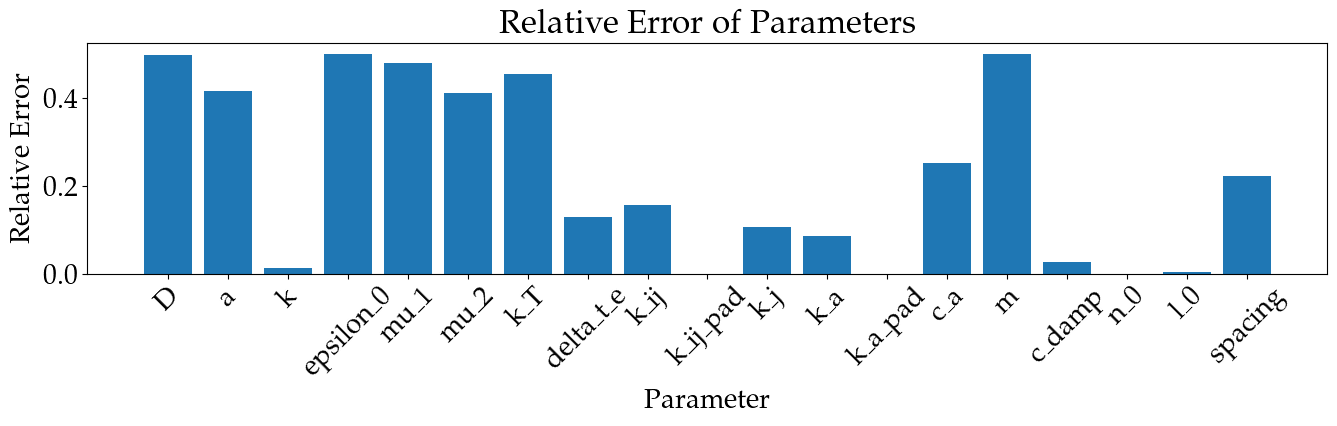

In [ ]:
#show diagram of all param errors
params_rec = dataset_MSD_2.params_train
param_names = list(params_true.keys())
relative_errors = []

for param_name in param_names:
    
    real_value = params_true.get(param_name, np.nan)
    train_value = params_rec.get(param_name, np.nan)
    if np.isnan(real_value) or np.isnan(train_value):
        relative_errors.append(np.nan)
    else:
        relative_error = np.abs((train_value - real_value) / real_value)
        relative_errors.append(relative_error)
# Plot the relative errors
plt.figure(figsize=(16, 3))
plt.bar(param_names, relative_errors)
plt.xlabel('Parameter')
plt.ylabel('Relative Error')
plt.title('Relative Error of Parameters')
plt.xticks(rotation=45)
plt.show()


In [ ]:
x_rec_2 = dataset_MSD_2.ys_sol['x'][0]
x_dot_rec_2 = dataset_MSD_2.ys_sol['x_dot'][0]
T_rec_2 = dataset_MSD_2.ys_sol['T'][0]
u_rec_2 = dataset_MSD_2.ys_sol['u'][0]
v_rec_2 = dataset_MSD_2.ys_sol['v'][0]

u_sim_2 = Simulation_MSD_2.ys['u'][0]
vmin,vmax =  0,1
pad = 10

# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(u_rec_2[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(u_sim_2[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"Simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(10,8))

    # Plot dA_fit
    im1 = axes.matshow(u_err[frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=u_sim.shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=4)

Output()

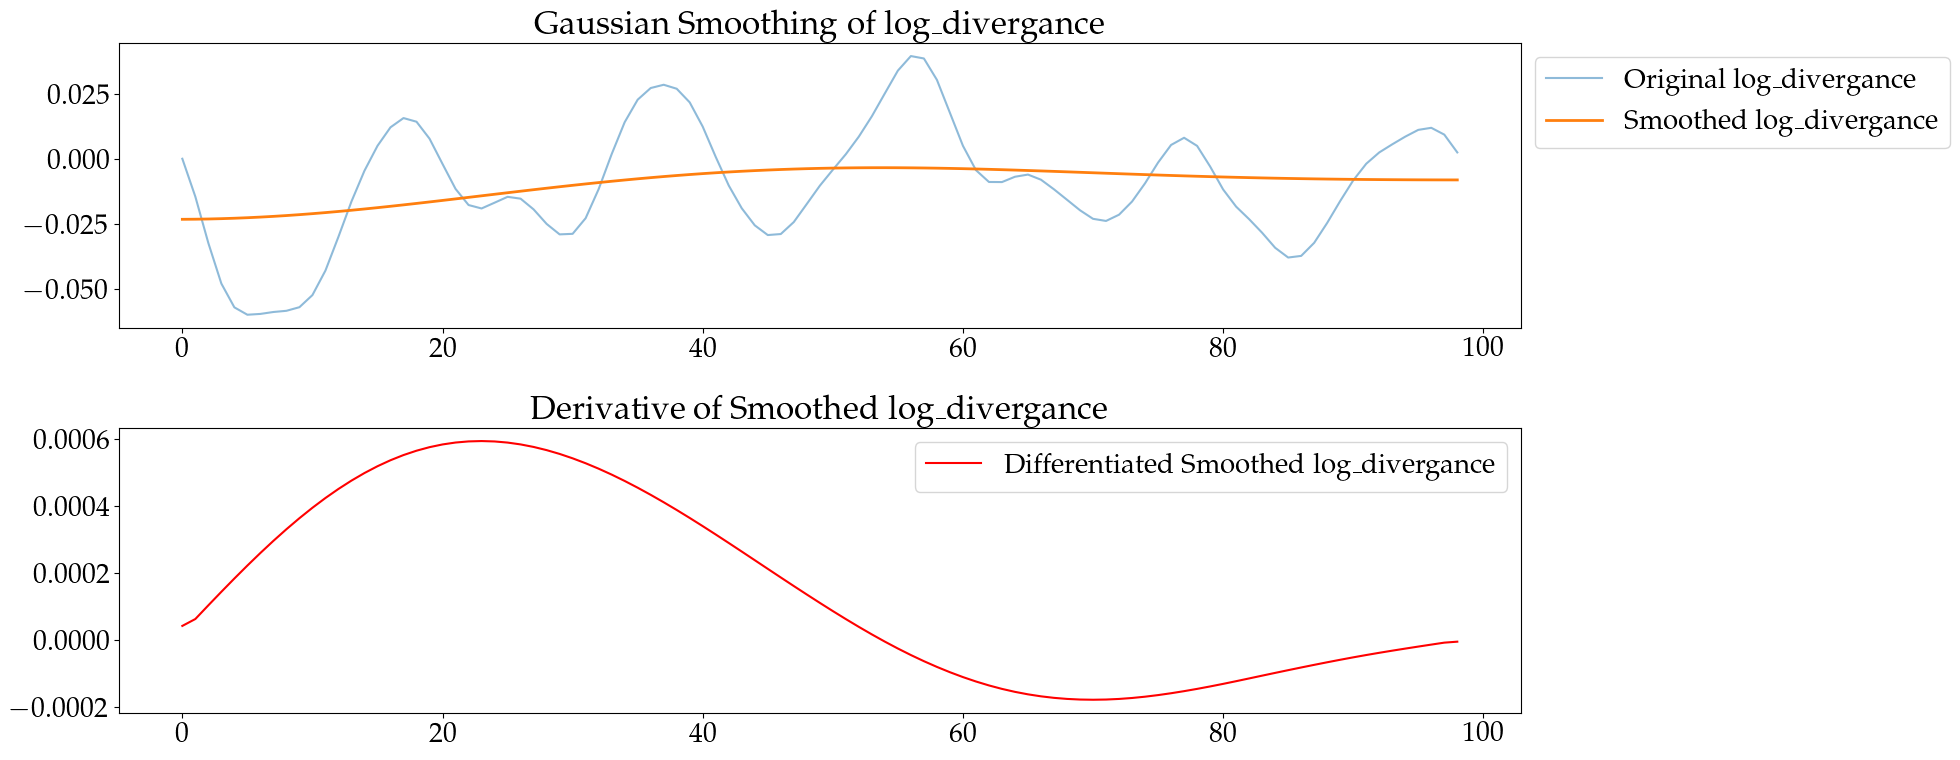

Largest Lyapunov exponent: 1681.756679991965


In [ ]:
data = u  # Simulated chaotic data

log_divergence= compute_log_div(data)

# Apply Gaussian smoothing
sigma = 20  # Adjust sigma for more or less smoothing
smoothed_data = gaussian_filter1d(log_divergence, sigma)

# Differentiate the smoothed data
differentiated_data = np.gradient(smoothed_data)

# Plot results
plt.figure(figsize=(20, 8))

# Original and Smoothed Data
plt.subplot(2, 1, 1)
plt.plot( log_divergence, label='Original log_divergance', alpha=0.5)
plt.plot( smoothed_data, label='Smoothed log_divergance', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Gaussian Smoothing of log_divergance')

# Differentiated Data
plt.subplot(2, 1, 2)
plt.plot( differentiated_data, label='Differentiated Smoothed log_divergance', color='red')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Derivative of Smoothed log_divergance')

plt.tight_layout()
plt.show()
print('Largest Lyapunov exponent:', 1/max(differentiated_data))